# 2025 COMP90042 Project
*Make sure you change the file name with your group id.*

# Readme
*If there is something to be noted for the marker, please mention here.*

*If you are planning to implement a program with Object Oriented Programming style, please put those the bottom of this ipynb file*

# 1.DataSet Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

# Read files

In [1]:
import json
import os

# Set paths
data_dir = "data"
train_claims_file = os.path.join(data_dir, "train-claims.json")
dev_claims_file = os.path.join(data_dir, "dev-claims.json")
test_claims_file = os.path.join(data_dir, "test_claims_retrieved_reranked.json")
evidence_file = os.path.join(data_dir, "evidence.json")

sep_token = "[SEP]"
cls_token = "[CLS]"

id2labels = ["SUPPORTS", "NOT_ENOUGH_INFO", "REFUTES", "DISPUTED"]
labels2id = {"SUPPORTS": 0, "NOT_ENOUGH_INFO": 1, "REFUTES": 2, "DISPUTED": 3}

# Load evidences
with open(evidence_file, 'r') as f:
    evidences = json.load(f)
print(f"Loaded {len(evidences)} evidence documents.")

# Load train claims
with open(train_claims_file, 'r') as f:
    train_claims = json.load(f)

train_data = []
for train_id in train_claims.keys():
    claim = train_claims[train_id]['claim_text']
    cur_evidences = train_claims[train_id]['evidences']
    evidence_texts = [evidences[evidence_id] for evidence_id in cur_evidences]
    train_input = cls_token + claim + sep_token.join(evidence_texts) + sep_token
    train_data.append({
        'input': train_input,
        'label': labels2id[train_claims[train_id]['claim_label']],
    })

print(f"Loaded {len(train_data)} train items.")

# Load dev claims
with open(dev_claims_file, 'r') as f:
    dev_claims = json.load(f)

dev_data = []
for dev_id in dev_claims.keys():
    claim = dev_claims[dev_id]['claim_text']
    cur_evidences = dev_claims[dev_id]['evidences']
    evidence_texts = [evidences[evidence_id] for evidence_id in cur_evidences]
    dev_input = cls_token + claim + sep_token.join(evidence_texts) + sep_token
    dev_data.append({
        'input': dev_input,
        'label': labels2id[dev_claims[dev_id]['claim_label']],
    })

print(f"Loaded {len(dev_data)} dev items.")

# Load test claims
with open(test_claims_file, 'r') as f:
    test_claims = json.load(f)

test_data = []
test_ids = list(test_claims.keys())
for test_id in test_ids:
    claim = test_claims[test_id]['claim_text']
    cur_evidences = test_claims[test_id]['evidences']
    evidence_texts = [evidences[evidence_id] for evidence_id in cur_evidences]
    test_input = cls_token + claim + sep_token.join(evidence_texts) + sep_token
    test_data.append({
        'input': test_input,
        'label': -1,  # Placeholder for test data labels
    })


Loaded 1208827 evidence documents.
Loaded 1228 train items.
Loaded 154 dev items.


In [2]:
import random
import numpy as np
import torch
seed = 330
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name, max_length=512)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(id2labels))

2025-05-14 13:54:50.593854: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-14 13:54:50.612511: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747202090.636633    5517 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747202090.644381    5517 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747202090.667314    5517 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [4]:
# DataLoader for train, and test data
from torch.utils.data import Dataset, DataLoader
import torch


class ClaimsDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        
        # Better processing method: using model's standard format
        if 'claim_text' in item and 'evidence_texts' in item:
            # Assuming each data item contains separate claim and evidences
            claim = item['claim_text']
            evidences = item['evidence_texts']
            evidence_text = " ".join(evidences[:3])  # Limit number of evidences to avoid truncation
            
            inputs = self.tokenizer(
                claim,                 # Claim as the first text
                evidence_text,         # Evidence as the second text
                padding='max_length',
                truncation='longest_first',
                max_length=self.max_length,
                return_tensors="pt"
            )
        else:
            # Compatible with existing input format
            inputs = self.tokenizer(
                item['input'], 
                padding='max_length', 
                truncation=True, 
                max_length=self.max_length,
                return_tensors="pt"
            )
            
        label = torch.tensor(item['label'])
        
        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'labels': label
        }
    
    def collate_fn(self, batch):
        input_ids = torch.stack([item['input_ids'] for item in batch])
        attention_mask = torch.stack([item['attention_mask'] for item in batch])
        labels = torch.stack([item['labels'] for item in batch])
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }
    

In [5]:
batch_size = 32

train_dataset = ClaimsDataset(train_data, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)

dev_dataset = ClaimsDataset(dev_data, tokenizer)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False, collate_fn=dev_dataset.collate_fn)

test_dataset = ClaimsDataset(test_data, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=test_dataset.collate_fn)


# 2. Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

### Label Smoothing Loss

In [6]:
# Define Label Smoothing Loss class
import torch.nn as nn
import torch.nn.functional as F

class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # Create smoothed label distribution
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [7]:
from tqdm import tqdm

def validate_model_with_exposure_mitigation(model, exposure_mitigator, dataloader, device, criterion=None):
    model.eval()
    exposure_mitigator.training = False
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc=f"[Validating]")
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass using exposure mitigator
            logits = exposure_mitigator.forward_with_scheduled_sampling(
                input_ids=input_ids, 
                attention_mask=attention_mask, 
                labels=labels
            )
            
            # Use label smoothing loss or default cross entropy
            if criterion is not None:
                loss = criterion(logits, labels)
            else:
                loss = F.cross_entropy(logits, labels)

            total_loss += loss.item()
            _, preds = torch.max(logits, dim=1)
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions

    model.train()  # Set model back to training mode
    return avg_loss, accuracy

### Exposure Bias Mitigation for Scheduled Sampling

In [8]:
# Implementation of scheduled sampling to mitigate exposure bias
class ExposureBiasMitigator:
    def __init__(self, model, device, num_labels, decay_rate=0.01):
        """
        Args:
            model: The classification model
            device: The device to run on
            num_labels: Number of classification labels
            decay_rate: Rate at which to decrease teacher forcing probability
        """
        self.model = model
        self.device = device
        self.num_labels = num_labels
        self.decay_rate = decay_rate
        self.teacher_forcing_prob = 1.0
        
    def update_teacher_forcing_prob(self, epoch):
        """Decrease teacher forcing probability as training progresses"""
        self.teacher_forcing_prob = max(0.0, 1.0 - self.decay_rate * epoch)
        return self.teacher_forcing_prob
        
    def forward_with_scheduled_sampling(self, input_ids, attention_mask, labels):
        """Forward pass with scheduled sampling to mitigate exposure bias"""
        # Initial forward pass with all real inputs
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        # Apply scheduled sampling for a second forward pass
        if self.training and random.random() > self.teacher_forcing_prob:
            # Generate pseudo-labels based on model prediction
            with torch.no_grad():
                pseudo_probs = F.softmax(logits, dim=-1)
                # Sample from the distribution
                pseudo_labels = torch.multinomial(pseudo_probs, 1).squeeze(-1)
            
            # Create token type ids based on pseudo-labels
            # This simulates the model being conditioned on its own predictions
            token_type_ids = torch.zeros_like(input_ids)
            for i, label in enumerate(pseudo_labels):
                # Set token type based on predicted class
                token_type_ids[i, :] = label.item()
                
            # Second forward pass with token type ids from predicted labels
            if hasattr(self.model, 'token_type_embeddings'):
                # If model supports token type embeddings
                outputs = self.model(
                    input_ids=input_ids, 
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids
                )
                logits = outputs.logits
        
        return logits

### Homogeneous Ensemble run different random seeds

In [9]:
# Memory-efficient implementation of model ensemble techniques
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModelForSequenceClassification
import gc
from tqdm import tqdm

class EnsembleClassifier:
    """Memory-efficient implementation of homogeneous ensemble for fact verification"""
    def __init__(self, model_names, device, num_labels=3):
        """
        Args:
            model_names: List of model names to use in ensemble
            device: Device to run models on
            num_labels: Number of classification labels
        """
        self.model_names = model_names
        self.device = device
        self.num_labels = num_labels
        self.tokenizers = {}
        self.models = {}
        
    def _load_model(self, model_name):
        """Dynamically load and cache models to save memory"""
        if model_name in self.models:
            return self.models[model_name]
            
        # Clean memory before loading a new model
        gc.collect()
        torch.cuda.empty_cache()
        
        print(f"Loading model: {model_name}")
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name, 
            num_labels=self.num_labels
        ).to(self.device)
        
        # Cache for later use
        self.models[model_name] = model
        return model
        
    def _unload_models(self):
        """Unload all models to free memory"""
        for key in list(self.models.keys()):
            del self.models[key]
        self.models = {}
        gc.collect()
        torch.cuda.empty_cache()
    
    def homogeneous_ensemble(self, dataloader, model_name, model_checkpoint, num_runs=3):
        """Homogeneous ensemble - Train model multiple times with different seeds"""
        all_predictions = []
        all_logits = []
        
        # Use same model but with different random initializations
        base_model = self._load_model(model_name)
        
        for run in range(num_runs):
            print(f"Run {run+1}/{num_runs}")
            
            # Set different seed for each run
            torch.manual_seed(330 + run)
            torch.cuda.manual_seed_all(330 + run)
            
            # Load the model checkpoint but with different initialization for some layers
            model = self._load_model(model_name)
            
            # Optionally load some pre-trained weights
            if model_checkpoint:
                model.load_state_dict(torch.load(model_checkpoint), strict=False)
                
            # Get predictions for this run
            model.eval()
            run_logits = []
            
            with torch.no_grad():
                for batch in tqdm(dataloader, desc=f"Evaluating run {run+1}"):
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                    batch_logits = outputs.logits
                    run_logits.append(batch_logits)
            
            # Concat all batch logits
            run_logits = torch.cat(run_logits, dim=0).cpu()
            all_logits.append(run_logits)
            
            # Free memory
            del model
            gc.collect()
            torch.cuda.empty_cache()
        
        # Combine predictions from all runs (average logits)
        avg_logits = torch.stack(all_logits).mean(dim=0)
        _, predictions = torch.max(avg_logits, dim=1)
        
        return predictions.numpy()

## Train

In [10]:
from transformers import AutoModelForSequenceClassification
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from tqdm.notebook import tqdm
from transformers import get_linear_schedule_with_warmup
import torch.nn as nn

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

# Initialize exposure bias mitigator
exposure_mitigator = ExposureBiasMitigator(model, device, len(id2labels), decay_rate=0.05)

# Define optimizer and learning rate
learning_rate = 1e-5
# Define number of epochs
num_epochs = 20
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

# Add learning rate scheduler to improve training stability
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=100,  # Warmup steps
    num_training_steps=total_steps
)



# Validation interval
val_interval = 100

# Logging interval
log_interval = 20

# Define label smoothing loss function
criterion = LabelSmoothingLoss(classes=len(id2labels), smoothing=0.1)

# Training loop
best_val_acc = 0.0
best_model_state = None

step = 0
model.train()
# Training phase

for epoch in range(num_epochs):

    # if step > 120:
    #         break
    # Update teacher forcing probability
    tf_prob = exposure_mitigator.update_teacher_forcing_prob(epoch)
    print(f"Epoch {epoch+1}/{num_epochs} - Teacher forcing probability: {tf_prob:.4f}")
    
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")
    for batch in progress_bar:
        # if step > 120:
        #     break

        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        optimizer.zero_grad()
        # outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        # logits = outputs.logits
        exposure_mitigator.training = True
        logits = exposure_mitigator.forward_with_scheduled_sampling(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            labels=labels
        )

        # Use label smoothing loss
        loss = criterion(logits, labels)
        
        # Backward pass
        loss.backward()
        

         # Gradient clipping to prevent gradient explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        # Update progress bar
        progress_bar.set_postfix({"loss": loss.item(), "lr": scheduler.get_last_lr()[0]})
        step += 1

        if step % log_interval == 0:
            print(f"Step {step}: Loss: {loss.item():.4f}, LR: {scheduler.get_last_lr()[0]:.7f}")

        # Validation phase
        if step % val_interval == 0:
            # Set exposure mitigator to eval mode
            exposure_mitigator.training = False
            val_loss, val_accuracy = validate_model_with_exposure_mitigation(
                model, exposure_mitigator, dev_dataloader, device, criterion
            )
            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

            # Save best model based on validation F1
            if val_accuracy > best_val_acc:
                best_val_acc = val_accuracy
                print(f"New best model found! Validation Accuracy: {val_accuracy:.4f}")
                # Save the model state
                torch.save(model.state_dict(), "best_classification_model.pth")
                # Early stopping if accuracy reaches high threshold
                if val_accuracy > 0.75:
                    print(f"Reached high accuracy ({val_accuracy:.4f}). Early stopping.")
                    break

print(f"Training complete! Best validation accuracy: {best_val_acc:.4f}")


Using device: cuda
Epoch 1/20 - Teacher forcing probability: 1.0000


Epoch 1/20 [Training]:   0%|          | 0/39 [00:00<?, ?it/s]

Step 20: Loss: 1.3881, LR: 0.0000020
Epoch 2/20 - Teacher forcing probability: 0.9500


Epoch 2/20 [Training]:   0%|          | 0/39 [00:00<?, ?it/s]

Step 40: Loss: 1.3142, LR: 0.0000040
Step 60: Loss: 1.2798, LR: 0.0000060
Epoch 3/20 - Teacher forcing probability: 0.9000


Epoch 3/20 [Training]:   0%|          | 0/39 [00:00<?, ?it/s]

Step 80: Loss: 1.2627, LR: 0.0000080
Step 100: Loss: 1.1329, LR: 0.0000100


[Validating]:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 1.2323, Validation Accuracy: 0.5325
New best model found! Validation Accuracy: 0.5325
Epoch 4/20 - Teacher forcing probability: 0.8500


Epoch 4/20 [Training]:   0%|          | 0/39 [00:00<?, ?it/s]

Step 120: Loss: 1.0500, LR: 0.0000097
Step 140: Loss: 1.0097, LR: 0.0000094
Epoch 5/20 - Teacher forcing probability: 0.8000


Epoch 5/20 [Training]:   0%|          | 0/39 [00:00<?, ?it/s]

Step 160: Loss: 0.9519, LR: 0.0000091
Step 180: Loss: 0.9200, LR: 0.0000088
Epoch 6/20 - Teacher forcing probability: 0.7500


Epoch 6/20 [Training]:   0%|          | 0/39 [00:00<?, ?it/s]

Step 200: Loss: 0.9874, LR: 0.0000085


[Validating]:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 1.0970, Validation Accuracy: 0.5974
New best model found! Validation Accuracy: 0.5974
Step 220: Loss: 0.8915, LR: 0.0000082
Epoch 7/20 - Teacher forcing probability: 0.7000


Epoch 7/20 [Training]:   0%|          | 0/39 [00:00<?, ?it/s]

Step 240: Loss: 0.8124, LR: 0.0000079
Step 260: Loss: 0.8384, LR: 0.0000076
Epoch 8/20 - Teacher forcing probability: 0.6500


Epoch 8/20 [Training]:   0%|          | 0/39 [00:00<?, ?it/s]

Step 280: Loss: 0.8420, LR: 0.0000074
Step 300: Loss: 0.6802, LR: 0.0000071


[Validating]:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.9980, Validation Accuracy: 0.6753
New best model found! Validation Accuracy: 0.6753
Epoch 9/20 - Teacher forcing probability: 0.6000


Epoch 9/20 [Training]:   0%|          | 0/39 [00:00<?, ?it/s]

Step 320: Loss: 0.7584, LR: 0.0000068
Step 340: Loss: 0.8331, LR: 0.0000065
Epoch 10/20 - Teacher forcing probability: 0.5500


Epoch 10/20 [Training]:   0%|          | 0/39 [00:00<?, ?it/s]

Step 360: Loss: 0.6939, LR: 0.0000062
Step 380: Loss: 0.8304, LR: 0.0000059
Epoch 11/20 - Teacher forcing probability: 0.5000


Epoch 11/20 [Training]:   0%|          | 0/39 [00:00<?, ?it/s]

Step 400: Loss: 0.8439, LR: 0.0000056


[Validating]:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.9794, Validation Accuracy: 0.7078
New best model found! Validation Accuracy: 0.7078
Step 420: Loss: 0.6995, LR: 0.0000053
Epoch 12/20 - Teacher forcing probability: 0.4500


Epoch 12/20 [Training]:   0%|          | 0/39 [00:00<?, ?it/s]

Step 440: Loss: 0.7142, LR: 0.0000050
Step 460: Loss: 0.6516, LR: 0.0000047
Epoch 13/20 - Teacher forcing probability: 0.4000


Epoch 13/20 [Training]:   0%|          | 0/39 [00:00<?, ?it/s]

Step 480: Loss: 0.8082, LR: 0.0000044
Step 500: Loss: 0.7932, LR: 0.0000041


[Validating]:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 0.9803, Validation Accuracy: 0.6883
Epoch 14/20 - Teacher forcing probability: 0.3500


Epoch 14/20 [Training]:   0%|          | 0/39 [00:00<?, ?it/s]

Step 520: Loss: 0.6608, LR: 0.0000038
Step 540: Loss: 0.7995, LR: 0.0000035
Epoch 15/20 - Teacher forcing probability: 0.3000


Epoch 15/20 [Training]:   0%|          | 0/39 [00:00<?, ?it/s]

Step 560: Loss: 0.6486, LR: 0.0000032
Step 580: Loss: 0.6713, LR: 0.0000029
Epoch 16/20 - Teacher forcing probability: 0.2500


Epoch 16/20 [Training]:   0%|          | 0/39 [00:00<?, ?it/s]

Step 600: Loss: 0.9028, LR: 0.0000026


[Validating]:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 1.0241, Validation Accuracy: 0.6558
Step 620: Loss: 0.6037, LR: 0.0000024
Epoch 17/20 - Teacher forcing probability: 0.2000


Epoch 17/20 [Training]:   0%|          | 0/39 [00:00<?, ?it/s]

Step 640: Loss: 0.7332, LR: 0.0000021
Step 660: Loss: 0.7272, LR: 0.0000018
Epoch 18/20 - Teacher forcing probability: 0.1500


Epoch 18/20 [Training]:   0%|          | 0/39 [00:00<?, ?it/s]

Step 680: Loss: 0.5898, LR: 0.0000015
Step 700: Loss: 0.5980, LR: 0.0000012


[Validating]:   0%|          | 0/5 [00:00<?, ?it/s]

Validation Loss: 1.0251, Validation Accuracy: 0.6688
Epoch 19/20 - Teacher forcing probability: 0.1000


Epoch 19/20 [Training]:   0%|          | 0/39 [00:00<?, ?it/s]

Step 720: Loss: 0.7020, LR: 0.0000009
Step 740: Loss: 0.5377, LR: 0.0000006
Epoch 20/20 - Teacher forcing probability: 0.0500


Epoch 20/20 [Training]:   0%|          | 0/39 [00:00<?, ?it/s]

Step 760: Loss: 0.7885, LR: 0.0000003
Step 780: Loss: 0.5904, LR: 0.0000000
Training complete! Best validation accuracy: 0.7078


# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

Running Homogeneous Ensemble...
Loading model: distilbert-base-uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Run 1/3


Evaluating run 1: 100%|██████████| 5/5 [00:00<00:00, 14.05it/s]


Run 2/3


Evaluating run 2: 100%|██████████| 5/5 [00:00<00:00, 13.95it/s]


Run 3/3


Evaluating run 3: 100%|██████████| 5/5 [00:00<00:00, 14.11it/s]



Prediction Distribution:
Counter({'NOT_ENOUGH_INFO': 112, 'SUPPORTS': 37, 'DISPUTED': 4})


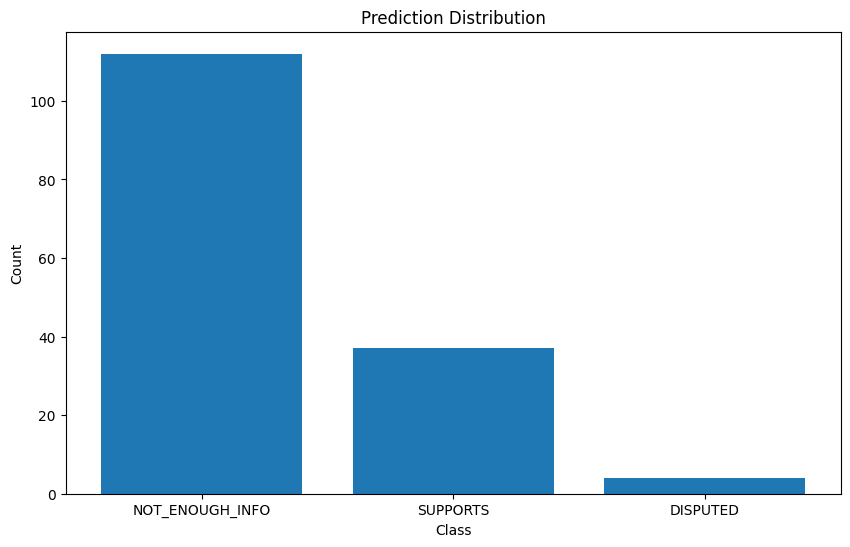


Results saved to classification_results.json


In [11]:
import json
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Define model to use
model_name = "distilbert-base-uncased"  # Use the model you've trained with

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create ensemble classifier
ensemble = EnsembleClassifier([model_name], device, num_labels=len(id2labels))

# Run homogeneous ensemble
print("Running Homogeneous Ensemble...")
predictions = ensemble.homogeneous_ensemble(
    test_dataloader,
    model_name=model_name,
    model_checkpoint="best_classification_model.pth",
    num_runs=3
)
predicted_labels = [id2labels[pred] for pred in predictions]

# Visualize results
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # If ground truth is available
    if 'ground_truth' in locals() and ground_truth:
        # Convert labels to IDs
        label2id = {v: k for k, v in id2labels.items()}
        gt_ids = [label2id[label] for label in ground_truth]
        
        # Calculate confusion matrix
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(gt_ids, predictions)
        
        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=list(id2labels.values()),
                   yticklabels=list(id2labels.values()))
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Homogeneous Ensemble Confusion Matrix')
        plt.tight_layout()
        plt.savefig('homogeneous_confusion_matrix.png', dpi=300)
        plt.show()
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(gt_ids, predictions, target_names=list(id2labels.values())))
    else:
        # Just show prediction distribution
        from collections import Counter
        print("\nPrediction Distribution:")
        print(Counter(predicted_labels))
        
        # Plot distribution
        plt.figure(figsize=(10, 6))
        counter = Counter(predicted_labels)
        plt.bar(counter.keys(), counter.values())
        plt.title('Prediction Distribution')
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.savefig('prediction_distribution.png', dpi=300)
        plt.show()
        
except ImportError:
    print("Could not generate visualization (matplotlib or seaborn not available)")

# Create results dictionary
results = {}
for i, test_id in enumerate(test_ids):
    results[test_id] = {
        'claim_text': test_claims[test_id]['claim_text'],
        'claim_label': predicted_labels[i],
        'evidences': test_claims[test_id]['evidences']
    }

# Save results to file
with open('classification_results.json', 'w') as f:
    json.dump(results, f, indent=4)

print("\nResults saved to classification_results.json")

## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*